Connect with google drive, and copy the sample data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !cp -r drive/MyDrive/data/project_jl/. .

Mounted at /content/drive


In [ ]:
!cp -r drive/MyDrive/data/project_jl/. .

Install and update libraries.

In [ ]:
import pandas as pd
import numpy as np
import warnings, csv
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [ ]:
# symbols = ["BTCUSDT","SOLUSDT","PNUTUSDT","TURBOUSDT","APTUSDT","AIXBTUSDT","TAOUSDT","KAITOUSDT","OMUSDT","XRPUSDT","FETUSDT","UNIUSDT","COMPUSDT","THEUSDT","AVAXUSDT","LTCUSDT","ETCUSDT","FORMUSDT","TONUSDT","HFTUSDT","DOTUSDT","CHESSUSDT","MKRUSDT","WIFUSDT"]
# selected_symbols = ["BTCUSDT","SOLUSDT","PNUTUSDT","TURBOUSDT","APTUSDT","AIXBTUSDT","TAOUSDT","KAITOUSDT","OMUSDT"]
# selected_symbols = ["BTCUSDT","FETUSDT","AVAXUSDT", "ETCUSDT","HFTUSDT","WIFUSDT"]

# symbols = ["AVAXUSDT","CHESSUSDT","TONUSDT"]
symbols = ["AVAXUSDT"]
# symbols = ["CHESSUSDT"]
# symbols = ["TONUSDT"]
# selected_symbols = symbols.copy()

# basis_name, label = 'basis_book_snapshot_5_AVAXUSDT.csv', '2 days backtest'
basis_name, label = f'basis_book_snapshot_5_{symbols[0]}_3w.csv', '3 weeks backtest'

df_basis = pd.read_csv(basis_name)

# Convert 'local_timestamp' to datetime and set as index
df_basis['local_timestamp'] = pd.to_datetime(df_basis['local_timestamp'])
df_basis = df_basis.set_index('local_timestamp')
# display(df_basis.info())
# df_basis[['swap.bids[0].price', 'swap.asks[0].price','swap.bids[1].price', 'swap.asks[1].price', 'swap.bids[2].price', 'swap.asks[2].price']] = df_basis[['swap.bids[0].price', 'swap.asks[0].price','swap.bids[1].price', 'swap.asks[1].price', 'swap.bids[2].price', 'swap.asks[2].price']].apply(np.log)
# df_basis[['spot.bids[0].price', 'spot.asks[0].price', 'spot.bids[1].price', 'spot.asks[1].price', 'spot.bids[2].price', 'spot.asks[2].price',]] = df_basis[['spot.bids[0].price', 'spot.asks[0].price', 'spot.bids[1].price', 'spot.asks[1].price', 'spot.bids[2].price', 'spot.asks[2].price',]].apply(np.log)
display(df_basis.info())
# print(df_basis.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1727981 entries, 2025-09-01 00:00:00 to 2025-09-20 23:59:59
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   spot.bids[0].price   float64
 1   spot.asks[0].price   float64
 2   spot.bids[1].price   float64
 3   spot.asks[1].price   float64
 4   spot.bids[2].price   float64
 5   spot.asks[2].price   float64
 6   spot.bids[0].amount  float64
 7   spot.asks[0].amount  float64
 8   spot.bids[1].amount  float64
 9   spot.asks[1].amount  float64
 10  spot.bids[2].amount  float64
 11  spot.asks[2].amount  float64
 12  swap.bids[0].price   float64
 13  swap.asks[0].price   float64
 14  swap.bids[1].price   float64
 15  swap.asks[1].price   float64
 16  swap.bids[2].price   float64
 17  swap.asks[2].price   float64
 18  swap.bids[0].amount  float64
 19  swap.asks[0].amount  float64
 20  swap.bids[1].amount  float64
 21  swap.asks[1].amount  float64
 22  swap.bids[2].amount  float64
 23 

None

In [ ]:
# display(df_basis.describe())

Starting backtest with strategy parameters:
RFI: 0.0600, b_0: 0.000303
TF_swap: 0.000250, TF_spot: 0.000250
rs: 0.000000, margin rate: 0.004000, Capital: 10000
Open trade at 2025-09-01 09:14:50: size=35.800000000000004, basis1=0.0130, portfolio=9999.17, position=35.800000000000004, USDT=9130.4586
Open trade at 2025-09-01 09:14:51: size=23.0, basis1=0.0190, portfolio=9998.43, position=58.800000000000004, USDT=8571.8132
Open trade at 2025-09-01 09:14:52: size=2.7, basis1=0.0280, portfolio=9997.71, position=61.50000000000001, USDT=8506.2308
Close trade at 2025-09-01 13:55:16: size=7.5, basis2=-0.0130, return=1.02, portfolio=10001.02
Close trade at 2025-09-01 13:55:17: size=54.00000000000001, basis2=-0.0120, return=0.96, portfolio=10000.96
Open trade at 2025-09-05 12:30:11: size=0.4, basis1=0.0140, portfolio=11488.99, position=0.4, USDT=9990.9392
Close trade at 2025-09-05 12:31:06: size=0.4, basis2=-0.0230, return=1489.00, portfolio=11489.00
Open trade at 2025-09-10 12:30:07: size=0.1, bas

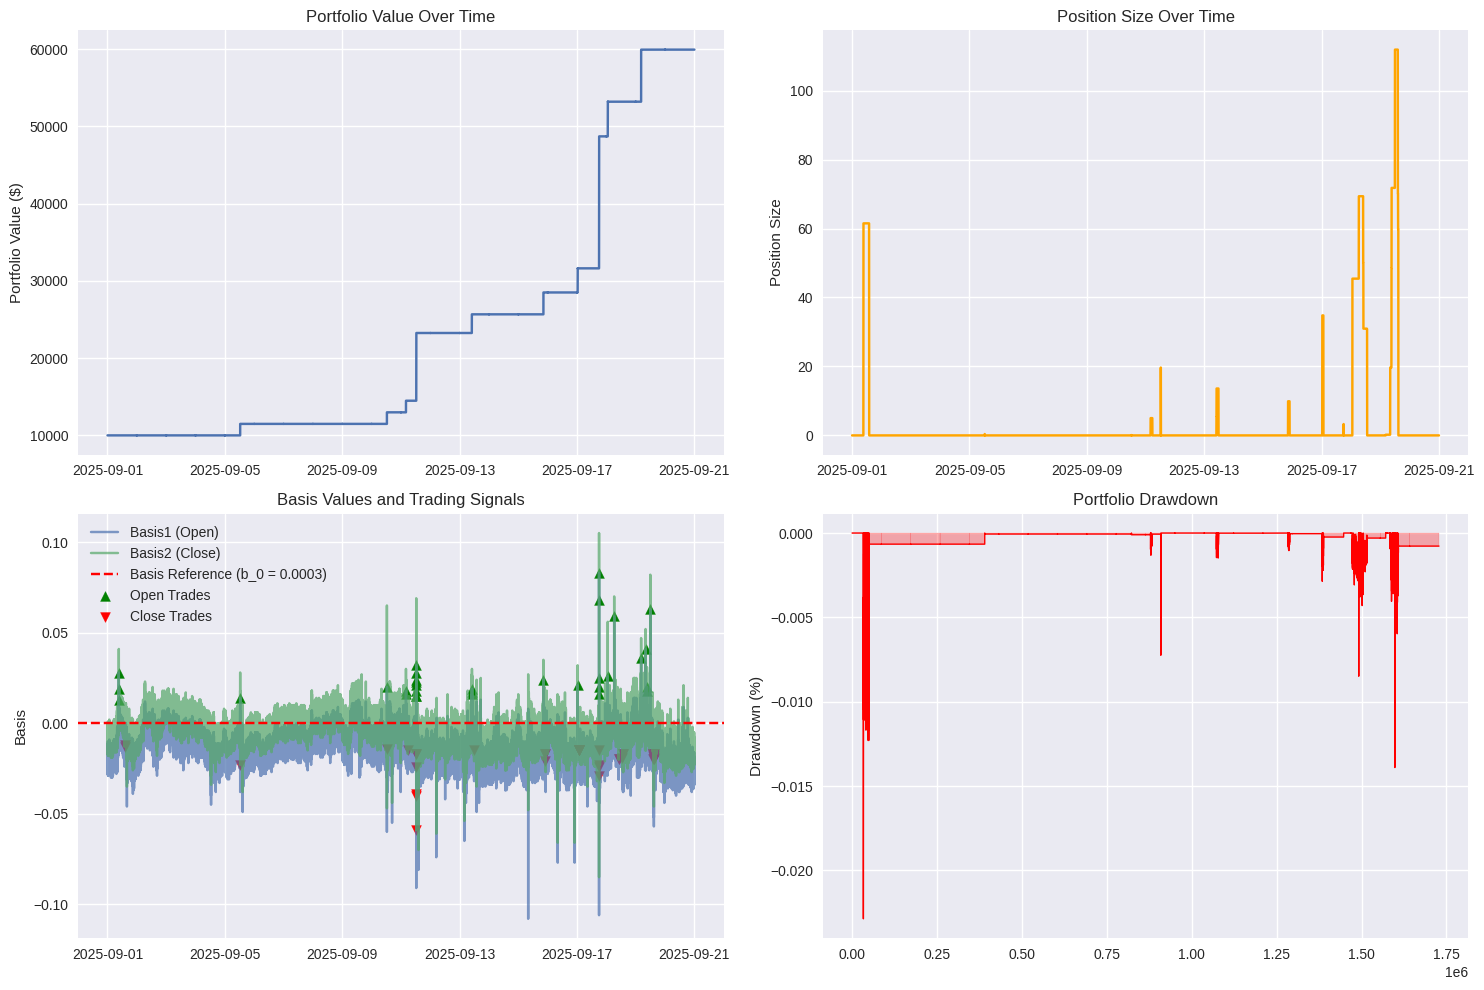

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

class BasisArbitrageBacktestV1:
    """
    Basis Arbitrage Backtesting System - Version 1
    Strictly follows the provided trading strategy formulas
    """

    def __init__(self, df, initial_capital=10000):
        """
        Initialize the backtest system

        Parameters:
        df: DataFrame with spot and swap market data
        initial_capital: Starting capital for trading
        """
        self.df = df.copy()
        self.initial_capital = initial_capital
        self.usdt = initial_capital

        self.r_m = 0.004 # Margin rate
        self.rr = 0.000 # rate of recalibrating price sliding


        # Fixed parameters
        self.RFI = 0.06  # 0.06% per day
        self.TF_swap = 0.00025  # 0.025% transaction fee for swap
        self.TF_spot = 0.00025  # 0.025% transaction fee for spot

        # Adjustable parameters
        self.rs = self.rr  # Sliding rate
        self.alpha = 0.1  # trade size
        self.rp = 0.1 # trade value / portfolio
        # self.PMax = 10000  # Maximum position size
        # self.N = 10000  # Total contract size

        # Basis reference point
        # self.b_0 = -3.130274e-03   # AVAX
        self.b_0 = 3.029702e-04  # TON

        # State variables
        # self.return_val = 0  # Cumulative return
        self.position = 0  # Current position
        self.entry_cost = 0  # Weighted average entry cost for contract
        self.contract_val = 0
        self.margin = 0

        # Results storage
        self.trades = []
        self.portfolio_values = []

    def run_backtest(self):
        """
        Execute the complete backtest based on the strategy rules
        """
        print("Starting backtest with strategy parameters:")
        print(f"RFI: {self.RFI:.4f}, b_0: {self.b_0:.6f}")
        print(f"TF_swap: {self.TF_swap:.6f}, TF_spot: {self.TF_spot:.6f}")
        print(f"rs: {self.rs:.6f}, margin rate: {self.r_m:.6f}, Capital: {self.usdt}")

        # Initialize tracking
        portfolio_value = self.usdt
        self.portfolio_values = [portfolio_value]
        self.contact_val = 0
        position_history = [0]
        return_history = [0]
        basis1_history = [0]
        basis2_history = [0]

        for i, (timestamp, row) in enumerate(self.df.iterrows()):
            # print(row)
            # current_portfolio = portfolio_value

            # 1. Calculate opening basis (basis1)
            basis1 = row['swap.bids[0].price'] - row['spot.asks[0].price']
            basis2 = row['swap.asks[0].price'] - row['spot.bids[0].price']

            swap_price = (row['swap.bids[0].price'] + row['swap.asks[0].price'])/2
            spot_price = (row['spot.bids[0].price'] + row['spot.asks[0].price'])/2

            # 1.5 Get trade sizes
            open_size = self.alpha * min(row['swap.bids[0].amount'], row['spot.asks[0].amount'])
            close_size = self.alpha * min(row['swap.asks[0].amount'], row['spot.bids[0].amount'])
            # 2. Opening condition check
            # n = self.alpha * self.N  # Position size for this trade

            # Calculate adjusted basis and transaction cost threshold
            basis1_adjusted = (1 - self.rr) * row['swap.bids[0].price'] - (1 + self.rr) * row['spot.asks[0].price']
            basis2_adjusted = (1 + self.rr) * row['swap.asks[0].price'] - (1 - self.rr) * row['spot.bids[0].price']
            basis1_history.append(basis1_adjusted)
            basis2_history.append(basis2_adjusted)
            # basis1_adjusted = basis1 / (1 + self.rs)
            transaction_cost_threshold = (self.TF_swap * swap_price + self.TF_spot * spot_price)

            # print(timestamp, len(self.df), self.rr, basis1, basis1_adjusted, transaction_cost_threshold)
            opening_condition = (basis1_adjusted - self.b_0) > transaction_cost_threshold
            max_position = self.rp * self.usdt / ((1 + self.rr) * row['spot.asks[0].price'] + swap_price * self.r_m)
            actual_open_size = min(open_size, max_position)
            # 3. Execute opening trade if conditions are met
            if opening_condition and actual_open_size > 0:
                # Calculate opening cost
                # opening_gain = n * (basis1 - self.TF_swap * row['swap.bids[0].price'] -
                #                   self.TF_spot * row['spot.asks[0].price'])
                n = actual_open_size
                self.contract_val += n * (1 - self.rs) * row['swap.bids[0].price']
                self.position += n
                self.entry_cost = self.contract_val / self.position
                self.usdt += n * (-(1 + self.rs) * row['spot.asks[0].price'] - transaction_cost_threshold) + self.margin
                self.margin = self.r_m * swap_price * self.position
                self.usdt -= self.margin

                # Calculate weighted average cost for multiple entries
                portfolio_value = self.usdt + self.margin + self.position*(row['spot.bids[0].price']+ (self.entry_cost - row['swap.asks[0].price']))
                # Record trade
                self.trades.append({
                    'timestamp': timestamp,
                    'action': 'open',
                    'size': n,
                    'basis1': basis1,
                    'marginal': self.margin,
                    'position_after': self.position,
                    'USDT_after': self.usdt,
                    'return_val': - self.initial_capital + portfolio_value
                })

                print(f"Open trade at {timestamp}: size={n}, basis1={basis1:.4f}, portfolio={(portfolio_value):.2f}, position={self.position}, USDT={self.usdt:.4f}")

                self.portfolio_values.append(portfolio_value)
                position_history.append(self.position)
                return_history.append(- self.initial_capital + portfolio_value)
                continue
            # 4. Calculate closing basis (basis2)
            # basis2 = row['swap.asks[0].price'] - row['spot.bids[0].price']
            # basis2_history.append(basis2)

            # 5. Closing condition check
            actual_close_size = min(close_size, self.position)
            if actual_close_size > 0 and self.b_0 - basis2_adjusted > transaction_cost_threshold:
                n = actual_close_size

                self.position -= n
                self.usdt += (self.entry_cost - (1 + self.rs) * row['swap.asks[0].price']) * n - transaction_cost_threshold
                self.contact_val = self.position * self.entry_cost
                self.usdt += (1 - self.rs) * row['spot.bids[0].price'] * n
                self.usdt += self.margin
                self.margin = self.position * self.r_m * swap_price
                self.usdt -= self.margin

                portfolio_value = self.usdt + self.margin + self.position*(row['spot.bids[0].price']+ (self.entry_cost - row['swap.asks[0].price']))
                # Record trade
                self.trades.append({
                    'timestamp': timestamp,
                    'action': 'close',
                    'size': n,
                    'basis2': basis2,
                    'position_after': self.position,
                    'marginal_after': self.margin,
                    'portfolio_value_after': self.usdt + self.margin,
                    'return_val': - self.initial_capital + portfolio_value
                })
                return_val = - self.initial_capital + portfolio_value
                print(f"Close trade at {timestamp}: size={n}, basis2={basis2:.4f}, return={return_val:.2f}, portfolio={portfolio_value:.2f}")

            if i == len(self.df) - 1 and self.position > 0:
                n = self.position

                self.position -= n
                self.usdt += (self.entry_cost - (1 + self.rs) * row['swap.asks[0].price']) * n
                self.contact_val = self.position * self.entry_cost
                self.usdt += (1 - self.rs) * row['spot.bids[0].price'] * n
                self.usdt += self.margin
                self.margin = self.position * self.r_m * swap_price
                self.usdt -= self.margin

                portfolio_value = self.usdt + self.margin + self.position*(row['spot.bids[0].price']+ (self.entry_cost - row['swap.asks[0].price']))
                # Record trade
                self.trades.append({
                    'timestamp': timestamp,
                    'action': 'close',
                    'size': n,
                    'basis2': basis2,
                    'pnl': 0,
                    'position_after': self.position,
                    'marginal_after': self.margin,
                    'portfolio_value_after': self.usdt + self.margin,
                    'return_val': - self.initial_capital + portfolio_value
                })
                return_val = - self.initial_capital + portfolio_value
                print(f"Last close trade at {timestamp}: size={n}, basis2={basis2:.4f}, return={return_val:.2f}, portfolio={portfolio_value:.2f}")


            # Update portfolio tracking
            portfolio_value = self.usdt + self.margin + self.position*(row['spot.bids[0].price']+ (self.entry_cost - row['swap.asks[0].price']))
            self.portfolio_values.append(portfolio_value)
            position_history.append(self.position)
            return_history.append(- self.initial_capital + portfolio_value)
            # if self.usdt + self.return_val < 1e-3:
            #   break

        # Store results in dataframe
        self.df['portfolio_value'] = self.portfolio_values[1:]
        self.df['position'] = position_history[1:]
        self.df['cumulative_return'] = return_history[1:]
        self.df['basis1'] = basis1_history[1:]
        self.df['basis2'] = basis2_history[1:]

        # Calculate performance metrics
        self._calculate_performance_metrics()

        print("\nBacktest completed")
        print(f"Final portfolio value: ${portfolio_value:,.2f}")
        print(f"Total trades: {len([t for t in self.trades if t['action'] == 'open'])}")

    def _calculate_performance_metrics(self):
        """
        Calculate performance metrics for the strategy
        """
        if len(self.portfolio_values) > 1:
            portfolio_returns = pd.Series(self.portfolio_values).pct_change().dropna()
            sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(365*24) if portfolio_returns.std() > 0 else 0
            volatility = portfolio_returns.std() * np.sqrt(365*24) if portfolio_returns.std() > 0 else 0
        else:
            sharpe_ratio = 0
            volatility = 0

        total_return_pct = (self.portfolio_values[-1] / self.initial_capital - 1) * 100 if self.usdt > 0 else 0

        self.results = {
            'total_return': total_return_pct,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': self._calculate_max_drawdown(self.portfolio_values),
            'volatility': volatility,
            'total_trades': len([t for t in self.trades if t['action'] == 'open']),
            # 'win_rate': self._calculate_win_rate(),
            # 'profit_factor': self._calculate_profit_factor(),
            'avg_trade_size': np.mean([t['size'] for t in self.trades if t['action'] == 'open']) if any(t['action'] == 'open' for t in self.trades) else 0,
            'max_position': max(self.df['position']) if len(self.df['position']) > 0 else 0,
            'final_portfolio_value': self.portfolio_values[-1] if len(self.portfolio_values) > 0 else self.initial_capital
        }

    def _calculate_max_drawdown(self, values):
        """
        Calculate maximum drawdown
        """
        if len(values) == 0:
            return 0

        peak = pd.Series(values).expanding().max()
        drawdown = (pd.Series(values) - peak) / peak
        return drawdown.min() * 100

    def _calculate_win_rate(self):
        """
        Calculate win rate of closing trades
        """
        close_trades = [t for t in self.trades if t['action'] == 'close']
        if not close_trades:
            return 0

        winning_trades = len([t for t in close_trades if t['pnl'] > 0])
        return (winning_trades / len(close_trades)) * 100

    def _calculate_profit_factor(self):
        """
        Calculate profit factor (gross profit / gross loss)
        """
        close_trades = [t for t in self.trades if t['action'] == 'close']
        if not close_trades:
            return 0

        gross_profit = sum(t['pnl'] for t in close_trades if t['pnl'] > 0)
        gross_loss = abs(sum(t['pnl'] for t in close_trades if t['pnl'] < 0))

        return gross_profit / gross_loss if gross_loss != 0 else float('inf')

    def plot_results(self):
        """
        Plot comprehensive backtest results
        """
        if len(self.df) == 0:
            print("No data to plot")
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Portfolio value
        ax1.plot(self.df.index, self.df['portfolio_value'])
        ax1.set_title('Portfolio Value Over Time')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.grid(True)

        # Plot 2: Position size
        ax2.plot(self.df.index, self.df['position'], color='orange')
        ax2.set_title('Position Size Over Time')
        ax2.set_ylabel('Position Size')
        ax2.grid(True)

        # Plot 3: Basis values and trading signals
        ax3.plot(self.df.index, self.df['basis1'], label='Basis1 (Open)', alpha=0.7)
        ax3.plot(self.df.index, self.df['basis2'], label='Basis2 (Close)', alpha=0.7)
        ax3.axhline(y=self.b_0, color='red', linestyle='--', label=f'Basis Reference (b_0 = {self.b_0:.4f})')

        # Mark opening trades
        open_trades = [t for t in self.trades if t['action'] == 'open']
        if open_trades:
            open_timestamps = [t['timestamp'] for t in open_trades]
            open_basis1 = [t['basis1'] for t in open_trades]
            ax3.scatter(open_timestamps, open_basis1, color='green', marker='^', s=50, label='Open Trades')

        # Mark closing trades
        close_trades = [t for t in self.trades if t['action'] == 'close']
        if close_trades:
            close_timestamps = [t['timestamp'] for t in close_trades]
            close_basis2 = [t['basis2'] for t in close_trades]
            ax3.scatter(close_timestamps, close_basis2, color='red', marker='v', s=50, label='Close Trades')

        ax3.set_title('Basis Values and Trading Signals')
        ax3.set_ylabel('Basis')
        ax3.legend()
        ax3.grid(True)

        # Plot 4: Drawdown
        if len(self.portfolio_values) > 0:
            peak = pd.Series(self.portfolio_values).expanding().max()
            drawdown = (pd.Series(self.portfolio_values) - peak) / peak * 100
            ax4.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.3, color='red')
            ax4.plot(drawdown, color='red', linewidth=1)
            ax4.set_title('Portfolio Drawdown')
            ax4.set_ylabel('Drawdown (%)')
            ax4.grid(True)

        plt.tight_layout()
        plt.show()

    def print_parameters(self):
        """
        Print strategy parameters
        """
        print("\n" + "="*60)
        print("STRATEGY PARAMETERS")
        print("="*60)
        print(f"RFI (Interest Rate): {self.RFI:.4%} per day")
        print(f"Swap Transaction Fee: {self.TF_swap:.4%}")
        print(f"Spot Transaction Fee: {self.TF_spot:.4%}")
        print(f"Sliding Rate (rs): {self.rs:.4f}")
        # print(f"Position Sizing Ratio (alpha): {self.alpha:.2f}")
        # print(f"Maximum Position (PMax): {self.PMax:,.0f}")
        # print(f"Total Contract Size (N): {self.N:,.0f}")
        print(f"Basis Reference (b_0): {self.b_0:.6f}")
        print("="*60)

    def print_performance_report(self):
        """
        Print comprehensive performance report
        """
        self.print_parameters()

        print("\n" + "="*60)
        print("PERFORMANCE RESULTS")
        print("="*60)
        print(f"Initial Capital: ${self.initial_capital:,.2f}")
        print(f"Final Portfolio Value: ${self.results['final_portfolio_value']:,.2f}")
        print(f"Total Return: {self.results['total_return']:.2f}%")
        print(f"Sharpe Ratio: {self.results['sharpe_ratio']:.2f}")
        print(f"Maximum Drawdown: {self.results['max_drawdown']:.2f}%")
        print(f"Annualized Volatility: {self.results['volatility']:.2f}%")
        print(f"Total Trades: {self.results['total_trades']}")
        # print(f"Win Rate: {self.results['win_rate']:.2f}%")
        print(f"Profit Factor: {self.results['profit_factor']:.2f}")
        print(f"Average Trade Size: {self.results['avg_trade_size']:,.0f}")
        print(f"Maximum Position: {self.results['max_position']:,.0f}")
        print("="*60)

    def get_trade_log(self):
        """
        Return detailed trade log
        """
        return pd.DataFrame(self.trades)

    def get_parameter_sensitivity(self, param_ranges):
        """
        Analyze sensitivity to parameter changes

        Parameters:
        param_ranges: Dictionary with parameter ranges to test
        """
        results = []

        for rs in param_ranges.get('rs', [self.rs]):
            for alpha in param_ranges.get('alpha', [self.alpha]):
                for pmax in param_ranges.get('PMax', [self.PMax]):
                    # Create new backtest instance
                    backtest = BasisArbitrageBacktestV1(self.df, self.initial_capital)
                    backtest.rs = rs
                    backtest.alpha = alpha
                    backtest.PMax = pmax

                    # Run backtest
                    backtest.run_backtest()

                    # Store results
                    results.append({
                        'rs': rs,
                        'alpha': alpha,
                        'PMax': pmax,
                        'total_return': backtest.results['total_return'],
                        'sharpe_ratio': backtest.results['sharpe_ratio'],
                        'max_drawdown': backtest.results['max_drawdown'],
                        'total_trades': backtest.results['total_trades']
                    })

        return pd.DataFrame(results)

# Main execution function
def run_strategy_backtest(df, initial_capital=100000, **kwargs):
    """
    Run the basis arbitrage backtest with specified parameters

    Parameters:
    df: DataFrame with market data
    initial_capital: Starting capital
    **kwargs: Parameter overrides
    """
    backtest = BasisArbitrageBacktestV1(df, initial_capital)

    # Override default parameters if provided
    # for key, value in kwargs.items():
    #     if hasattr(backtest, key):
    #         setattr(backtest, key, value)
    #         print(f"Setting {key} = {value}")

    backtest.run_backtest()
    # backtest.print_performance_report()
    backtest.plot_results()

    return backtest

# Example usage with parameter optimization
def optimize_strategy_parameters(df, param_ranges):
    """
    Optimize strategy parameters using grid search

    Parameters:
    df: DataFrame with market data
    param_ranges: Dictionary of parameter ranges to test
    """
    best_sharpe = -np.inf
    best_params = {}
    best_backtest = None

    for rs in param_ranges.get('rs', [0.001]):
        for alpha in param_ranges.get('alpha', [0.1]):
            for pmax in param_ranges.get('PMax', [10000]):
                backtest = BasisArbitrageBacktestV1(df)
                backtest.rs = rs
                backtest.alpha = alpha
                backtest.PMax = pmax

                backtest.run_backtest()

                if backtest.results['sharpe_ratio'] > best_sharpe:
                    best_sharpe = backtest.results['sharpe_ratio']
                    best_params = {'rs': rs, 'alpha': alpha, 'PMax': pmax}
                    best_backtest = backtest

    print(f"Best Sharpe Ratio: {best_sharpe:.2f}")
    print(f"Best Parameters: {best_params}")

    return best_backtest

# Execute backtest

# Example usage:
# backtest = run_strategy_backtest(df_basis, initial_capital=100000)

# With custom parameters:
backtest = run_strategy_backtest(
    df_basis,
    initial_capital=10000
)

# Parameter optimization:
# param_ranges = {
#     'rs': [0.0005, 0.001, 0.002],
#     'alpha': [0.05, 0.1, 0.2],
#     'PMax': [5000, 10000, 15000]
# }
# best_backtest = optimize_strategy_parameters(df, param_ranges)
# print(backtest.df.describe())

In [ ]:
print(backtest.df.describe())

       spot.bids[0].price  spot.asks[0].price  spot.bids[1].price  \
count        1.727967e+06        1.727967e+06        1.727967e+06   
mean         3.139938e+00        3.140938e+00        3.138938e+00   
std          4.690131e-02        4.690131e-02        4.690131e-02   
min          2.998000e+00        2.999000e+00        2.997000e+00   
25%          3.099000e+00        3.100000e+00        3.098000e+00   
50%          3.136000e+00        3.137000e+00        3.135000e+00   
75%          3.175000e+00        3.176000e+00        3.174000e+00   
max          3.265000e+00        3.266000e+00        3.264000e+00   

       spot.asks[1].price  spot.bids[2].price  spot.asks[2].price  \
count        1.727967e+06        1.727967e+06        1.727967e+06   
mean         3.141938e+00        3.137938e+00        3.142938e+00   
std          4.690131e-02        4.690131e-02        4.690131e-02   
min          3.000000e+00        2.996000e+00        3.001000e+00   
25%          3.101000e+00        